# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Dropout, Dense
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Prepare Data

In [2]:
images = []
labels = []

data = pd.read_csv('data/instagram_data.csv')
for image in os.listdir("data/images"):
    if "_".join(image.split('_')[1:]).split('.')[0] in data.imagename.tolist():
        row = data.loc[data['imagename'] == "_".join(image.split('_')[1:]).split('.')[0]]
        images.append(image)
        if row['Q5A.  If yes to Q5, what type of Asian'].values[0] == 1:
            labels.append(1)
        else:
            labels.append(0)

pd.DataFrame({"filename": images, "label": labels}).to_csv('data/processed_instagram_data.csv', index=False)

# Import data

In [2]:
IMG_DIR = 'data/images'
IMG_SIZE = 224
CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 32
NUM_EPOCHS = 10

train_data = pd.read_csv('data/processed_instagram_data.csv', dtype='string')
X_length = len(train_data)
Y = train_data[['label']]

skf = StratifiedKFold(n_splits = 5, shuffle = True) 

datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True,
                                   preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

# Model Definition

In [3]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def new_model():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
    vgg.trainable = False

    model = Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model

# Training

In [4]:
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_LOSS = []

save_dir = 'saved_models/'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(X_length),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = datagen.flow_from_dataframe(training_data, directory = IMG_DIR,
						    x_col = "filename", y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
						    shuffle = True)
	valid_data_generator  = datagen.flow_from_dataframe(validation_data, directory = IMG_DIR,
							x_col = "filename", y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
						    shuffle = True)
	
	model = new_model()
	model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=[Precision(), Recall(), 'accuracy'])

	checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	
	callbacks_list = [checkpoint]

	history = model.fit(train_data_generator,
			    epochs=NUM_EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)

	model.load_weights("saved_models/model_"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))

	if fold_var == 1:
		VALIDATION_ACCURACY.append(results['accuracy'])
		VALIDATION_PRECISION.append(results['precision'])
		VALIDATION_RECALL.append(results['recall'])
		VALIDATION_LOSS.append(results['loss'])
	else:
		VALIDATION_ACCURACY.append(results['accuracy'])
		VALIDATION_PRECISION.append(results['precision_'+str(fold_var-1)])
		VALIDATION_RECALL.append(results['recall_'+str(fold_var-1)])
		VALIDATION_LOSS.append(results['loss'])
	
	fold_var += 1

Found 2983 validated image filenames belonging to 2 classes.
Found 746 validated image filenames belonging to 2 classes.
Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 0.7281 - precision: 0.8347 - recall: 0.8347 - accuracy: 0.8347
Epoch 00001: val_accuracy improved from -inf to 0.85389, saving model to saved_models/model_1.h5
94/94 [==============================] - 24s 182ms/step - loss: 0.7281 - precision: 0.8347 - recall: 0.8347 - accuracy: 0.8347 - val_loss: 0.3643 - val_precision: 0.8539 - val_recall: 0.8539 - val_accuracy: 0.8539
Epoch 2/10
94/94 [==============================] - ETA: 0s - loss: 0.3347 - precision: 0.8592 - recall: 0.8592 - accuracy: 0.8592
Epoch 00002: val_accuracy did not improve from 0.85389
94/94 [==============================] - 13s 139ms/step - loss: 0.3347 - precision: 0.8592 - recall: 0.8592 - accuracy: 0.8592 - val_loss: 0.3358 - val_precision: 0.8539 - val_recall: 0.8539 - val_accuracy: 0.8539
Epoch 3/10
94/94 [===================

In [5]:
accuracy = np.average(VALIDATION_ACCURACY)
precision = np.average(VALIDATION_PRECISION)
recall = np.average(VALIDATION_RECALL)

print("5-Fold Cross Validation Accuracy: ", accuracy)
print("5-Fold Cross Validation Precision: ", precision)
print("5-Fold Cross Validation Recall: ", recall)

5-Fold Cross Validation Accuracy:  0.8680605411529541
5-Fold Cross Validation Precision:  0.8680605411529541
5-Fold Cross Validation Recall:  0.8680605411529541


In [6]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

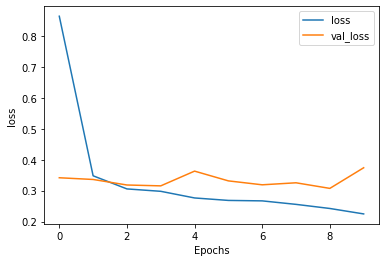

In [7]:
plot_graphs(history, 'loss')

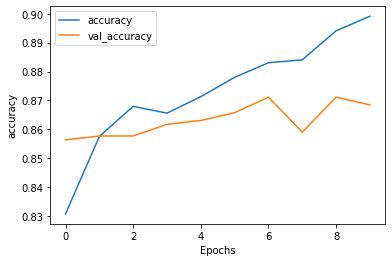

In [8]:
plot_graphs(history, 'accuracy')